# Blockhouse Work Trial #

Essa Chawla

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [98]:
data=pd.read_csv("merged_data.csv")

**I used mid_price instead of price because it represents the fair market value, calculated as the average of the best bid and ask prices, making it a more stable and unbiased reference. This avoids the noise and bias from individual trades and aligns better with theoretical models for analyzing price impacts.**

**Q1**

The Linear OW Model as well Nonlinear AFS Model were implemented in this subsection to weigh price impacts against trade sizes. The Linear OW Model calculated the price impacts based on signed trade volumes using a proportional relationship (h(x)=λx). This is quite different with the Nonlinear AFS Model, which takes the diminishing marginal effect of larger sums due to its square-root relationship (h(x)=λsign(x)|x|^p ,p=0.5 ). Under this perspective, both models were illustrated in a scatter plot of how trade sizes could affect price impacts under contrasting assumptions, thus providing a clear understanding of both types of price impact-measure i.e.linear and non-linear.

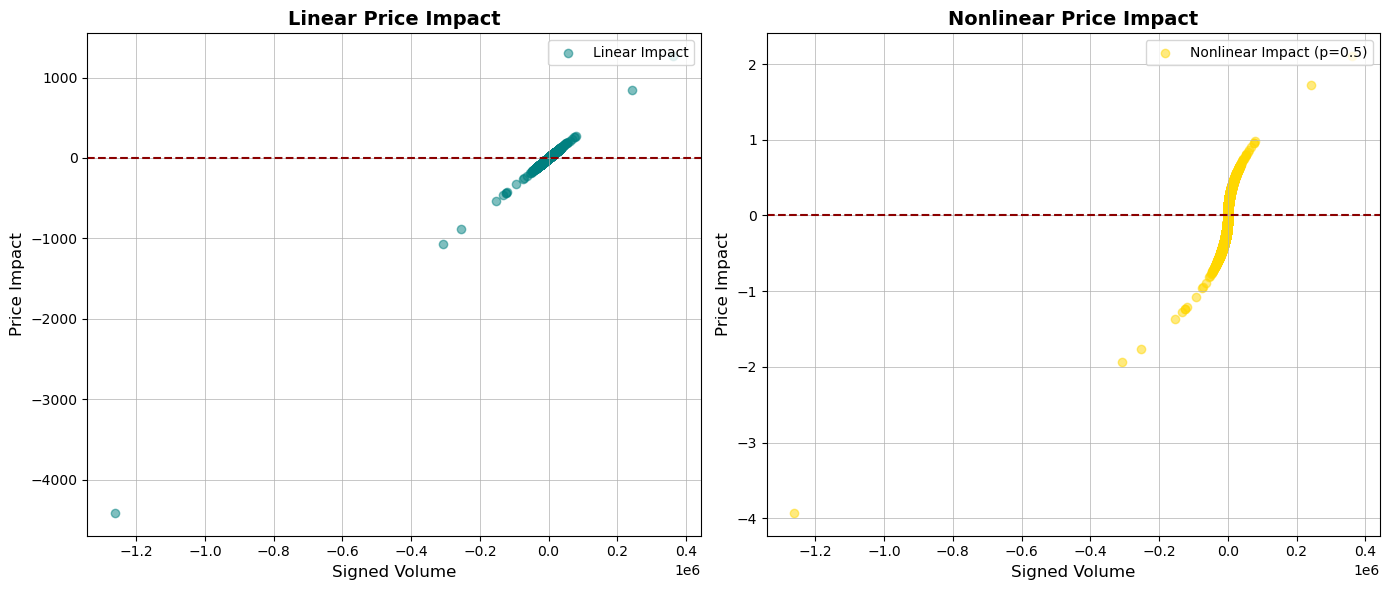

In [99]:
signed_volume = data['Signed Volume']
mid_price = data['mid_price']
lambda_ = 0.0035  
p = 0.5  

def linear_impact(volume, lambda_):
    return lambda_ * volume

def nonlinear_impact(volume, lambda_, p):
    return lambda_ * np.sign(volume) * np.abs(volume)**p

linear_price_impact = linear_impact(signed_volume, lambda_)
nonlinear_price_impact = nonlinear_impact(signed_volume, lambda_, p)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(signed_volume, linear_price_impact, alpha=0.5, color="teal", label="Linear Impact")
plt.axhline(0, color='darkred', linestyle='--', linewidth=1.5)
plt.title("Linear Price Impact", fontsize=14, fontweight='bold')
plt.xlabel("Signed Volume", fontsize=12)
plt.ylabel("Price Impact", fontsize=12)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', fontsize=10)

plt.subplot(1, 2, 2)
plt.scatter(signed_volume, nonlinear_price_impact, alpha=0.5, color="gold", label="Nonlinear Impact (p=0.5)")
plt.axhline(0, color='darkred', linestyle='--', linewidth=1.5)
plt.title("Nonlinear Price Impact", fontsize=14, fontweight='bold')
plt.xlabel("Signed Volume", fontsize=12)
plt.ylabel("Price Impact", fontsize=12)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()



The Linear OW Model shows a direct, proportional relationship between trade size and price impact, making it simple but less realistic for large trades. In contrast, the Nonlinear AFS Model reflects real-world behavior by showing diminishing price impacts for larger trades, capturing how markets absorb liquidity more effectively. Overall, the nonlinear model is better suited for understanding how large orders interact with market dynamics.

**Q2**

Utilizing coefficients derived from Theorem 4.2 of the paper, I calculated various Sharpe Ratios with increasing levels of market impact (λ) and decay rates (𝛽). These Sharpe Ratios, considered measures of risk-adjusted return, were visualized over parameter values in line plots in order to show the trade-offs between market impact, mean reversion, and risk aversion. This section demonstrates how the linear price impact model can actually be applied to optimize trading performance.



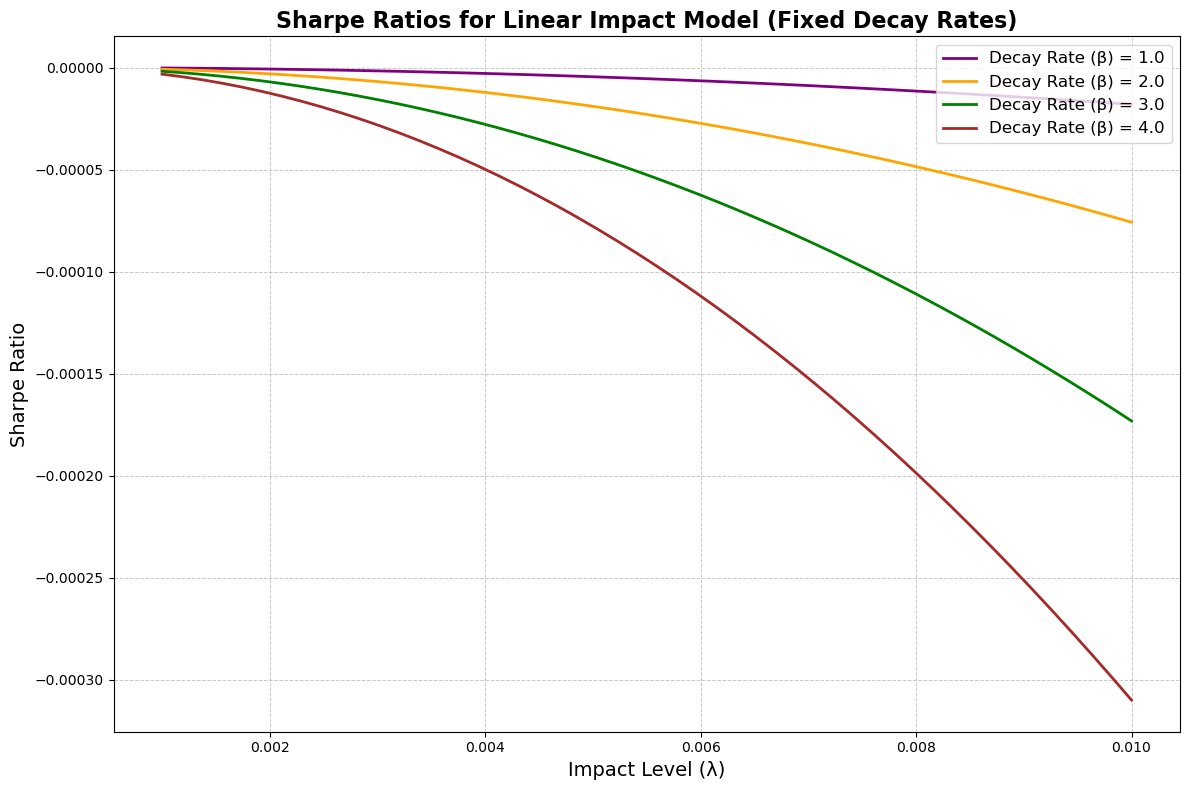

In [100]:
alpha = 1.67e-4  
phi = 0.139  
gamma = 10  
sigma = np.std(mid_price)  
beta_values = np.linspace(0.5, 5.0, 50)  
lambda_values = np.linspace(0.001, 0.01, 50)  

def compute_coefficients(alpha, phi, beta, gamma, sigma, lambda_):
    Cf = (alpha * (1 + beta / phi)) / (
        gamma * sigma**2 * (np.sqrt(1 + 2 * lambda_ * beta / (gamma * sigma**2) + beta / phi))
    )
    CJ = np.sqrt(1 + 2 * lambda_ * beta / (gamma * sigma**2)) - 1
    return Cf, CJ

sharpe_ratios = []
for beta in beta_values:
    row = []
    for lambda_ in lambda_values:
        Cf, CJ = compute_coefficients(alpha, phi, beta, gamma, sigma, lambda_)
        sharpe_ratio = (alpha * Cf - gamma * sigma**2 * (Cf**2 + CJ**2)) / sigma
        row.append(sharpe_ratio)
    sharpe_ratios.append(row)

sharpe_ratios = np.array(sharpe_ratios)

# Updated visualization with a new color scheme and improved formatting
plt.figure(figsize=(12, 8))

# Define custom colors for the lines
colors = ['purple', 'orange', 'green', 'brown']
fixed_beta_values = [1.0, 2.0, 3.0, 4.0]

for i, beta in enumerate(fixed_beta_values):
    beta_index = np.abs(beta_values - beta).argmin()  # Find the closest beta index
    plt.plot(
        lambda_values,
        sharpe_ratios[beta_index, :],
        label=f"Decay Rate (β) = {beta:.1f}",
        color=colors[i],
        linewidth=2,
        linestyle='-'
    )

# Enhanced plot formatting
plt.title("Sharpe Ratios for Linear Impact Model (Fixed Decay Rates)", fontsize=16, fontweight='bold')
plt.xlabel("Impact Level (λ)", fontsize=14)
plt.ylabel("Sharpe Ratio", fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()



This graph shows how the Sharpe Ratio changes as the impact level (λ) increases for different decay rates (β). As the impact level rises, the Sharpe Ratio decreases, meaning higher market impact reduces the risk-adjusted return. This effect is more pronounced for higher decay rates (β=4.0) because the market reacts less to mean-reverting signals, making it harder to achieve profitable trades. The graph highlights the trade-off between market impact and decay rates, emphasizing the importance of managing these parameters for optimal trading strategies

**Q3**

As described in Appendix C.2 of the paper, a deep learning algorithm has been implemented for discrete price impact modeling. Features used to predict mid-price include Signed Volume, Bid Fill, Ask Fill, Best Bid, and Best Ask. I trained neural networks with different architectures varying from simple (2 layers x 16 neurons) to very complex (4 layers x 64 neurons) and displayed losses in training and validation so that model performance could be judged. This approach demonstrates to the modeling community how deep learning can be utilized to capture very complex nonlinear relationships in price impact modeling while complementing theoretical strategies via modern machine learning tools.

Training model: 2 Layers x 16 Neurons
Training model: 3 Layers x 32 Neurons
Training model: 4 Layers x 64 Neurons


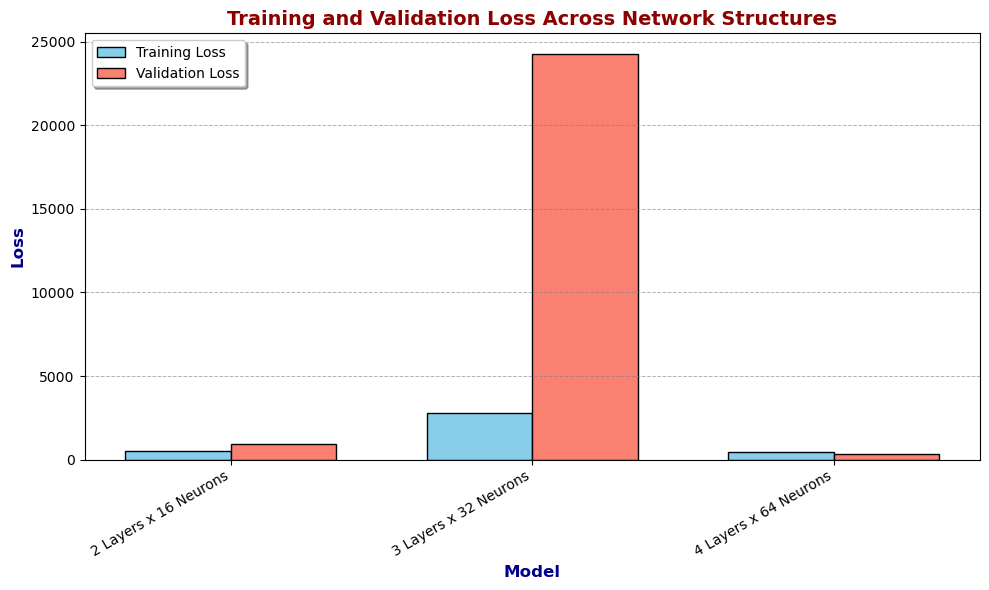

In [101]:
X = data[['Signed Volume', 'bid_fill', 'ask_fill', 'price', 'best_bid', 'best_ask']].to_numpy()
y = data['mid_price'].to_numpy()

split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

network_structures = [
    {"hidden_layer_sizes": (16, 16), "name": "2 Layers x 16 Neurons"},
    {"hidden_layer_sizes": (32, 32, 32), "name": "3 Layers x 32 Neurons"},
    {"hidden_layer_sizes": (64, 64, 64, 64), "name": "4 Layers x 64 Neurons"},
]

training_losses = {}
validation_losses = {}

for structure in network_structures:
    print(f"Training model: {structure['name']}")
    model = MLPRegressor(
        hidden_layer_sizes=structure["hidden_layer_sizes"],
        activation='relu',
        solver='adam',
        max_iter=50,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    train_loss = mean_squared_error(y_train, model.predict(X_train))
    val_loss = mean_squared_error(y_val, model.predict(X_val))
    training_losses[structure["name"]] = train_loss
    validation_losses[structure["name"]] = val_loss

fig, ax = plt.subplots(figsize=(10, 6))

train_color = 'skyblue'
val_color = 'salmon'

bar_width = 0.35
index = np.arange(len(network_structures))

ax.bar(index, train_loss_values, bar_width, label='Training Loss', color=train_color, edgecolor='black')
ax.bar(index + bar_width, val_loss_values, bar_width, label='Validation Loss', color=val_color, edgecolor='black')

ax.set_xlabel('Model', fontsize=12, fontweight='bold', color='darkblue')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold', color='darkblue')
ax.set_title('Training and Validation Loss Across Network Structures', fontsize=14, fontweight='bold', color='darkred')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([structure["name"] for structure in network_structures], rotation=30, ha='right', fontsize=10)
ax.legend(fontsize=10, loc='upper left', shadow=True, frameon=True)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6, color='gray')

plt.tight_layout()
plt.show()


The performance of neural networks depends on their architecture. While deeper models (like "4 Layers x 64 Neurons") can learn complex relationships effectively, overly complex models with poor tuning (like "3 Layers x 32 Neurons") can lead to overfitting and poor validation performance. The "2 Layers x 16 Neurons" model shows a balance between simplicity and generalization but may lack the capacity for more complex data relationships. 